### Introduction

The IMF Direction of Trade Statistics (DOTS) dataset contains trade information between countries, broken down by imports, exports, and other trade indicators. The raw data is very large and not in an immediately usable format, so the goal is to clean it, reshape it, and create visualizations that make it easier to understand how trade flows change over time.

We will be focusing on filtering for a specific country (like Russia or the United States), optionally comparing it with a trading partner, and plotting trends over time. The notebook is structured step by step: each code block is followed by a short explanation of what the code is doing and why it’s needed.

#### Step 1 – Import libraries

In [4]:
import re
from difflib import get_close_matches
import pandas as pd
import matplotlib.pyplot as plt

Explanation:
Here we're loading the libraries needed for the project. pandas handles data manipulation, matplotlib is for plotting, re is used for working with time-period strings like “2024-M03,” and difflib helps with fuzzy matching country names (so typing “Russia” can still match “Russian Federation” in the dataset).

#### Step 2 – Load header and detect important columns

In [7]:
CSV_PATH = "dataset_2025-09-22T02_37_55.202156816Z_DEFAULT_INTEGRATION_IMF.STA_IMTS_1.0.0.csv"

# ---- Read header → detect columns ----
hdr = pd.read_csv(CSV_PATH, nrows=0)
cols = hdr.columns.str.strip()
meta_candidates = ["COUNTRY", "COUNTERPART_COUNTRY", "FREQUENCY", "INDICATOR", "SCALE"]
meta_cols = [c for c in meta_candidates if c in cols]
period_cols = [c for c in cols if re.match(r"^\d{4}($|-M\d{2}$|-Q[1-4]$)", c)]

if "COUNTRY" not in meta_cols: raise KeyError("Expected 'COUNTRY' column.")
if not period_cols: raise ValueError("No period columns like '2024', '2025-M03', '2023-Q4' found.")

Explanation:
This block only loads the header row of the CSV (no data yet). The reason is that the file is huge, so we want to first check what columns exist. It identifies “metadata” columns (like COUNTRY and INDICATOR) and all the time-series columns (the ones that are years, months, or quarters). This step is basically scoping out the structure of the dataset before doing any heavy lifting.

#### Step 3 – Load only the columns we need

In [10]:
# ---- Load only needed columns ----
usecols = meta_cols + period_cols
df = pd.read_csv(CSV_PATH, usecols=usecols, low_memory=False)
df.columns = df.columns.str.strip()

Explanation:
Here we reload the dataset but only keep the important columns (the metadata and the time values). This makes the data frame much smaller and faster to work with. It also cleans up the column names so there are no stray spaces.

#### Step 4 – Show country names and resolve user input

In [13]:
# ---- Show available countries & build resolver ----
all_countries = sorted(df["COUNTRY"].dropna().astype(str).unique().tolist())
print(f"[INFO] Number of unique countries: {len(all_countries)}")
for c in all_countries:
    print("   •", c)

ALIASES = {
    "russia": "Russian Federation",
    "usa": "United States",
    "america": "United States",
    "united states of america": "United States",
    "south korea": "Korea, Republic of",
    "north korea": "Korea, Democratic People's Republic of",
    "czech republic": "Czech Republic",
    "ivory coast": "Côte d'Ivoire",
}

def resolve_name(name: str | None) -> str | None:
    if not name: return None
    n = name.strip()
    # exact
    for p in all_countries:
        if p.casefold() == n.casefold(): return p
    # alias
    alias = ALIASES.get(n.casefold())
    if alias in all_countries: return alias
    # substring
    contains = [p for p in all_countries if n.casefold() in p.casefold()]
    if len(contains) == 1: return contains[0]
    # fuzzy
    m = get_close_matches(n, all_countries, n=1, cutoff=0.6)
    return m[0] if m else None

[INFO] Number of unique countries: 237
   • Advanced Economies
   • Afghanistan, Islamic Republic of
   • Africa
   • Albania
   • Algeria
   • American Samoa
   • Angola
   • Anguilla, United Kingdom-British Overseas Territory
   • Antigua and Barbuda
   • Argentina
   • Armenia, Republic of
   • Aruba, Kingdom of the Netherlands
   • Australia
   • Austria
   • Azerbaijan, Republic of
   • Bahamas, The
   • Bahrain, Kingdom of
   • Bangladesh
   • Barbados
   • Belarus, Republic of
   • Belgium
   • Belgium-Luxembourg
   • Belize
   • Benin
   • Bermuda
   • Bhutan
   • Bolivia
   • Bosnia and Herzegovina
   • Botswana
   • Brazil
   • Brunei Darussalam
   • Bulgaria
   • Burkina Faso
   • Burundi
   • CIS
   • Cabo Verde
   • Cambodia
   • Cameroon
   • Canada
   • Central African Republic
   • Chad
   • Chile
   • China, People's Republic of
   • Colombia
   • Comoros, Union of the
   • Congo, Democratic Republic of the
   • Congo, Republic of
   • Costa Rica
   • Croatia, Republic

Explanation:
Since the IMF uses formal names (like “Russian Federation” instead of just “Russia”), this step prints out the countries in the dataset so we know what format is expected. This helps avoid errors later when filtering by country.

#### Step 5 – Ask the user for config

In [16]:
# ---- Ask user for config (CSV fixed) ----
country_raw = input("\nCOUNTRY (type as you like; I'll resolve it): ").strip() or "Russia"
partner_raw = input("PARTNER for bilateral plot (blank to skip): ").strip() or None
freq = input("FREQUENCY [Monthly/Quarterly/Annual] (blank for all): ").strip() or None
indicator_contains = input("INDICATOR filter [Exports/Imports] (blank for all): ").strip() or None

country = resolve_name(country_raw)
partner = resolve_name(partner_raw) if partner_raw else None
if not country:
    raise ValueError(f"Could not match COUNTRY='{country_raw}'. Try one of these: {all_countries[:10]} ...")
print(f"\n[INFO] Using COUNTRY name in file: {country}")
if partner_raw and not partner:
    print(f"[WARN] Could not match partner '{partner_raw}'. Bilateral plot will be skipped unless found later.")


COUNTRY (type as you like; I'll resolve it):  Russia
PARTNER for bilateral plot (blank to skip):  america
FREQUENCY [Monthly/Quarterly/Annual] (blank for all):  monthly
INDICATOR filter [Exports/Imports] (blank for all):  exports



[INFO] Using COUNTRY name in file: Russian Federation


Explanation:
Instead of hardcoding the country, partner, frequency, and indicator, this section asks the user for input. For example, we could enter Russia, United States, Monthly, and Exports. If we press Enter without typing anything, it falls back on defaults.

#### Step 6a – Show available frequencies and indicators

In [19]:
# ---- Country subset + show available freq/indicator text ----
subset = df[df["COUNTRY"].astype(str).str.casefold() == country.casefold()].copy()
if subset.empty:
    raise ValueError(f"No rows for COUNTRY='{country}' after load.")

avail_freq = (subset["FREQUENCY"].dropna().astype(str).unique().tolist()
              if "FREQUENCY" in subset.columns else [])
print(f"[INFO] Available FREQUENCY for {country}: {sorted(avail_freq)}")
if "INDICATOR" in subset.columns:
    print("[INFO] Example INDICATOR values (first up to 10):")
    for ex in subset["INDICATOR"].dropna().astype(str).unique()[:10]:
        print("   •", ex)

[INFO] Available FREQUENCY for Russian Federation: ['Annual', 'Monthly', 'Quarterly']
[INFO] Example INDICATOR values (first up to 10):
   • Imports of goods, Cost insurance freight (CIF), US dollar
   • Exports of goods, Free on board (FOB), US dollar
   • Trade balance goods, US dollar


What the code does:
This part filters the dataset down to just the chosen country. Once that’s done, it prints out which FREQUENCY values (Annual, Monthly, Quarterly) are available for that country. It also shows the first 10 examples of INDICATOR values (things like “Exports of goods, Free on board (FOB), US dollar” or “Imports of goods, cost insurance freight (CIF), US dollar”).

Why it matters:
The IMF dataset uses formal and sometimes technical labels. By showing what’s actually inside the file, the user knows what filters will work. For example, if I typed “Annual” but the data only has “Monthly,” this output warns me right away.

#### Step 6b – Apply filters safely (with fallback)

In [22]:
# ---- Apply safe filters (auto-relax if they nuke data) ----
if freq and "FREQUENCY" in subset.columns:
    before = len(subset)
    subset = subset[subset["FREQUENCY"].astype(str).str.casefold() == freq.casefold()]
    print(f"[INFO] FREQUENCY='{freq}': {before} → {len(subset)} rows")
    if subset.empty:
        print("[WARN] FREQUENCY removed (no rows). Reverting to country-only.")
        subset = df[df["COUNTRY"].astype(str).str.casefold() == country.casefold()].copy()

def indicator_mask(series: pd.Series, q: str | None) -> pd.Series:
    if not q: return pd.Series(True, index=series.index)
    q = q.strip().lower()
    if q in {"export", "exports"}: pat = r"\bexport"
    elif q in {"import", "imports"}: pat = r"\bimport"
    else: pat = re.escape(q)
    return series.astype(str).str.lower().str.contains(pat, na=False)

if "INDICATOR" in subset.columns and indicator_contains:
    before = len(subset)
    subset = subset[indicator_mask(subset["INDICATOR"], indicator_contains)]
    print(f"[INFO] INDICATOR~'{indicator_contains}': {before} → {len(subset)} rows")
    if subset.empty:
        print("[WARN] INDICATOR filter removed (no rows). Reverting to country-only.")
        subset = df[df["COUNTRY"].astype(str).str.casefold() == country.casefold()].copy()

if subset.empty:
    raise ValueError("No rows left after filters. Try removing frequency/indicator, or choose another country.")
print(f"[INFO] Rows after filters: {len(subset):,}")

[INFO] FREQUENCY='monthly': 2127 → 709 rows
[INFO] INDICATOR~'exports': 709 → 235 rows
[INFO] Rows after filters: 235


What the code does:
Here the code applies the filters step by step:

1. FREQUENCY filter – narrows the data to just Annual, Monthly, or Quarterly (if specified). If that removes everything, it warns us and automatically resets back to just the country filter.

2. INDICATOR filter – narrows by keywords like “Exports” or “Imports.” The filter is flexible: typing “Exports” will match any indicator that contains that word (like “Exports of goods, FOB, US dollar”). Again, if this removes all the rows, it warns us and falls back to country-only.

3. At the end it prints how many rows survived after all the filtering.

Why it matters:
It’s really easy to accidentally filter too aggressively in a dataset this large. For example, if we pick “Russia + Annual + Exports” but Russia doesn’t have annual data, we’d normally end up with an empty dataset. This block prevents that problem by automatically backing off on the filters, so we always have something left to analyze.

#### Step 7 – Melt the data (reshape from wide to long)

In [25]:
# ---- Melt only the filtered subset (fast) ----
id_vars = [c for c in ["COUNTRY","COUNTERPART_COUNTRY","FREQUENCY","INDICATOR","SCALE"] if c in subset.columns]
long = subset.melt(id_vars=id_vars, value_vars=period_cols,
                   var_name="Period", value_name="Value").dropna(subset=["Value"])

Explanation:
The IMF dataset stores each time period as a separate column, which is not convenient for analysis. “Melting” reshapes the dataset into a long format, where each row is (Country, Partner, Date, Value). This makes it much easier to plot time series.

#### Step 8 – Parse the “Period” into real dates

In [28]:
# ---- Parse 'Period' to month-end timestamps ----
def parse_period(p):
    if re.fullmatch(r"\d{4}", p):  # annual
        return pd.to_datetime(p) + pd.offsets.YearEnd(0)
    m = re.fullmatch(r"(\d{4})-M(\d{2})", p)
    if m:
        y, mm = int(m.group(1)), int(m.group(2))
        return pd.Timestamp(y, mm, 1) + pd.offsets.MonthEnd(0)
    q = re.fullmatch(r"(\d{4})-Q([1-4])", p)
    if q:
        y, qq = int(q.group(1)), int(q.group(2))
        return pd.Timestamp(y, [3,6,9,12][qq-1], 1) + pd.offsets.MonthEnd(0)
    return pd.NaT

long["Date"] = long["Period"].apply(parse_period)
long = long.dropna(subset=["Date"]).sort_values("Date")

Explanation:
The “Period” column is text like 2024, 2024-M03, or 2024-Q2. This function converts those strings into real datetime objects that Python can understand. For example, 2024-Q2 becomes the last day of June 2024. Having proper dates allows us to sort the data and plot it on a timeline.

Step 9 – Plot total trade for the chosen country

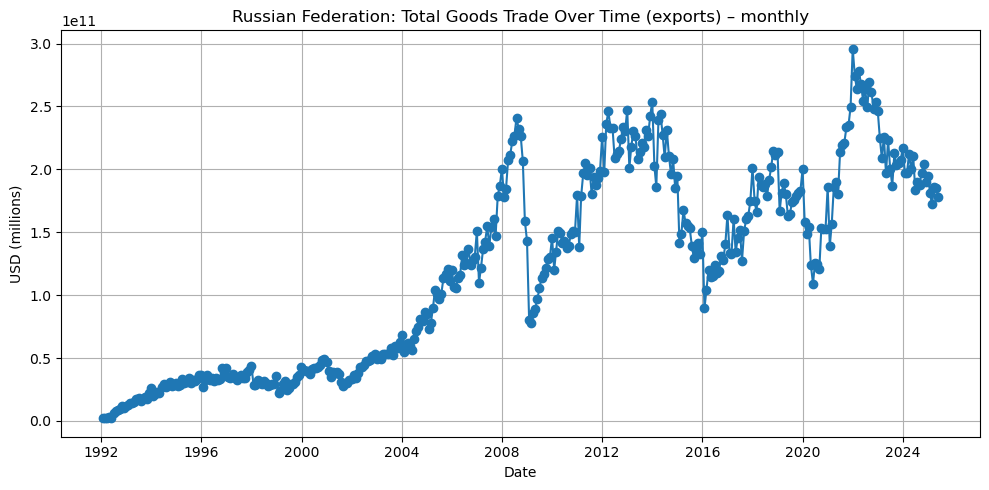

In [31]:
# ---- Plot A: Country total across partners ----
total = long.groupby("Date", as_index=False)["Value"].sum()
plt.figure(figsize=(10,5))
plt.plot(total["Date"], total["Value"], marker="o")
titleA = f"{country}: Total Goods Trade Over Time"
if indicator_contains: titleA += f" ({indicator_contains})"
if freq: titleA += f" – {freq}"
plt.title(titleA); plt.xlabel("Date"); plt.ylabel("USD (millions)")
plt.grid(True); plt.tight_layout(); plt.show()

Explanation:
This groups everything by date and sums across all partners, so we get the total exports or imports for the chosen country. The line chart makes it easy to see overall trade trends over time.

#### Step 10 – Plot bilateral trade (if a partner was given)

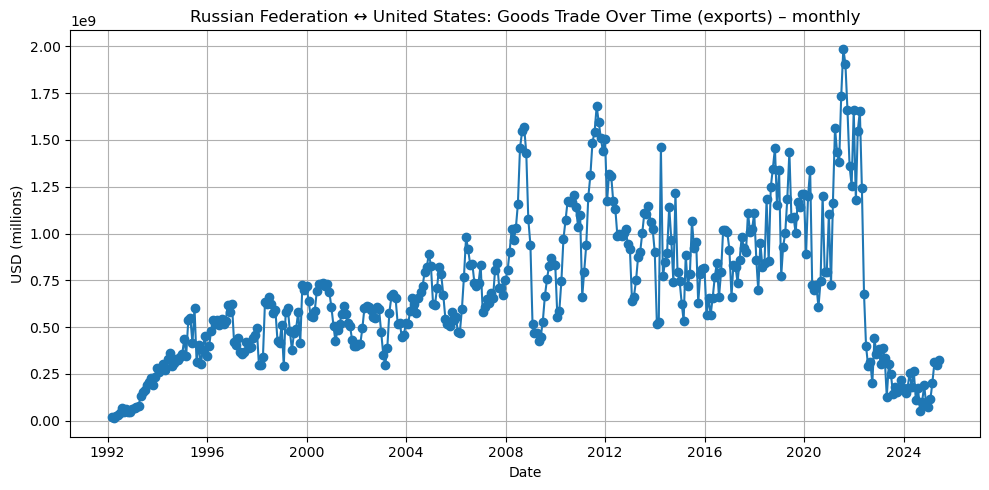

In [34]:
# ---- Plot B: Bilateral with chosen partner (if resolvable & present) ----
if partner and "COUNTERPART_COUNTRY" in long.columns:
    bilat = long[long["COUNTERPART_COUNTRY"].astype(str).str.casefold() == partner.casefold()]
    if not bilat.empty:
        plt.figure(figsize=(10,5))
        plt.plot(bilat["Date"], bilat["Value"], marker="o")
        titleB = f"{country} ↔ {partner}: Goods Trade Over Time"
        if indicator_contains: titleB += f" ({indicator_contains})"
        if freq: titleB += f" – {freq}"
        plt.title(titleB); plt.xlabel("Date"); plt.ylabel("USD (millions)")
        plt.grid(True); plt.tight_layout(); plt.show()
    else:
        print(f"[info] No bilateral rows for partner '{partner}'.")
else:
    print("[info] Partner not provided or COUNTERPART_COUNTRY not available; skipping bilateral plot.")


Explanation:
If I entered a partner country (like United States), this block plots the bilateral trade between my main country and that partner. If we didn’t provide a partner, or if there’s no data, it just skips this step.